#Setup

###Install

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
import torch

In [ ]:
print("PyTorch has version {}".format(torch.__version__))
# Install torch geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install ogb

In [5]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/My Drive/Dataset/wm-nowm"
train_path = root_dir + '/train' 
valid_path = root_dir + '/valid'

Mounted at /content/drive


###Read Images and Create Train/Test Datasets.

In [6]:
def takeFileName(filedir): # remove just file name from directory and return
    # filename = np.array(filedir.split('/'))[-1].split('.')[0] # take out the name, isolate the jpeg, then return the name
    filename = np.array(filedir.split('/'))[-1] # take out the name, then return the name
    # print(filename)
    return filename

def matchFileNames(watermarkedarr, nonwatermarkedarr, dname_wm, dname_nwm):
    sortedwmarr = np.array([])
    sortednwmarr = np.array([])
    
    wmarr = list(watermarkedarr)
    nwmarr = list(nonwatermarkedarr)
    
    length = len(watermarkedarr) if len(watermarkedarr) >= len(nonwatermarkedarr) else len(nonwatermarkedarr)
    
    for pos in range(length):
        try:
            if length == len(watermarkedarr): # more images in watermarked array
                exist_nwm = nwmarr.index(wmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[pos]) # this is the iterable
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[exist_nwm]) # this is the match
            elif length == len(nonwatermarkedarr): # more images in nonwatermarked array
                exist_wm = wmarr.index(nwmarr[pos])
                sortedwmarr = np.append(sortedwmarr, dname_wm + watermarkedarr[exist_wm]) # this is the match
                sortednwmarr = np.append(sortednwmarr, dname_nwm + nonwatermarkedarr[pos]) # this is the iterable
        except ValueError: 
            continue
    return sortedwmarr, sortednwmarr

In [7]:
# Sort the watermarked and non watermarked images into parallel arrays so NN will use it better

train_path_watermarked_images = train_path + '/watermark/'
train_path_nonwatermarked_images = train_path + '/no-watermark/'

tp_watermarked = np.array([]) # array with watermarked image names
tp_nonwatermarked = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(train_path_watermarked_images, topdown=True): # data length = 12510
    for file in files:
        tp_watermarked = np.append(tp_watermarked, takeFileName(file)) # append just the name of the file into array
    
for root, dirs, files in os.walk(train_path_nonwatermarked_images, topdown=True): # data length = 12477
    for file in files:
        tp_nonwatermarked = np.append(tp_nonwatermarked, takeFileName(file)) # append just the name of the file into array
        
tp_watermarked_sorted, tp_nonwatermarked_sorted = matchFileNames(tp_watermarked, tp_nonwatermarked, train_path_watermarked_images, train_path_nonwatermarked_images)


valid_path_watermarked_images = valid_path + '/watermark/'
valid_path_nonwatermarked_images = valid_path + '/no-watermark/'

vp_watermarked = np.array([]) # array with watermarked image names
vp_nonwatermarked = np.array([]) # array with nonwatermarked image names

for root, dirs, files in os.walk(valid_path_watermarked_images, topdown=True): # data length = 3299
    for file in files:
        vp_watermarked = np.append(vp_watermarked, takeFileName(file)) # append just the name of the file into array
    
for root, dirs, files in os.walk(valid_path_nonwatermarked_images, topdown=True): # data length = 3289
    for file in files:
        vp_nonwatermarked = np.append(vp_nonwatermarked, takeFileName(file)) # append just the name of the file into array
        
vp_watermarked_sorted, vp_nonwatermarked_sorted = matchFileNames(vp_watermarked, vp_nonwatermarked, valid_path_watermarked_images, valid_path_nonwatermarked_images)

In [8]:
# dimension to resize to 
width = 148 # only certain dimensions work due to UpSampling (196x196 works, 148x148 works)
height = 148
dim = (width, height) # set the dimensions

def createPixelArr(files):
    data = []
    for image in files:
        try: # take each image and use imread to get the pixel values in a matrix 
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # rescale the image so every image is of the same dimension
            data.append(resized_arr) # add the matrix of pixel values 
        except Exception as e:
            print(e) # some error thrown in imread or resize
    return np.array(data)

train_wms_pixVals = createPixelArr(tp_watermarked_sorted)
train_nwms_pixVals = createPixelArr(tp_nonwatermarked_sorted)

val_wms_pixVals = createPixelArr(vp_watermarked_sorted)
val_nwms_pixVals = createPixelArr(vp_nonwatermarked_sorted) # make ndarrays

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_wms_pixVals, train_nwms_pixVals, train_size=0.8, random_state=1)
# Garbage collection
train_wms_pixVals = 0 
train_nwms_pixVals = 0 
val_wms_pixVals = 0 
val_nwms_pixVals = 0 

In [ ]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
plt.show()

#Data Augmentation

###Data Augmentation Helper Functions

In [9]:
# Functions to data augment images 

def data_augmentation(inputImage): # run image through all augmentation methods
    return randomContrast(randomBrightness(inputImage)).numpy()
    # return randomCrop(randomFlip(inputImage)) # use augmentation methods without messing with colour 

def randomFlip(pic): # flips the image up and down before left and right at random
    return tf.image.random_flip_up_down(tf.image.random_flip_left_right(pic, 1), 1)

def randomBrightness(pic): # makes the image a random brightness from 1% to 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.2), 1)

def randomContrast(pic): # contrasts the image from 5% to 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

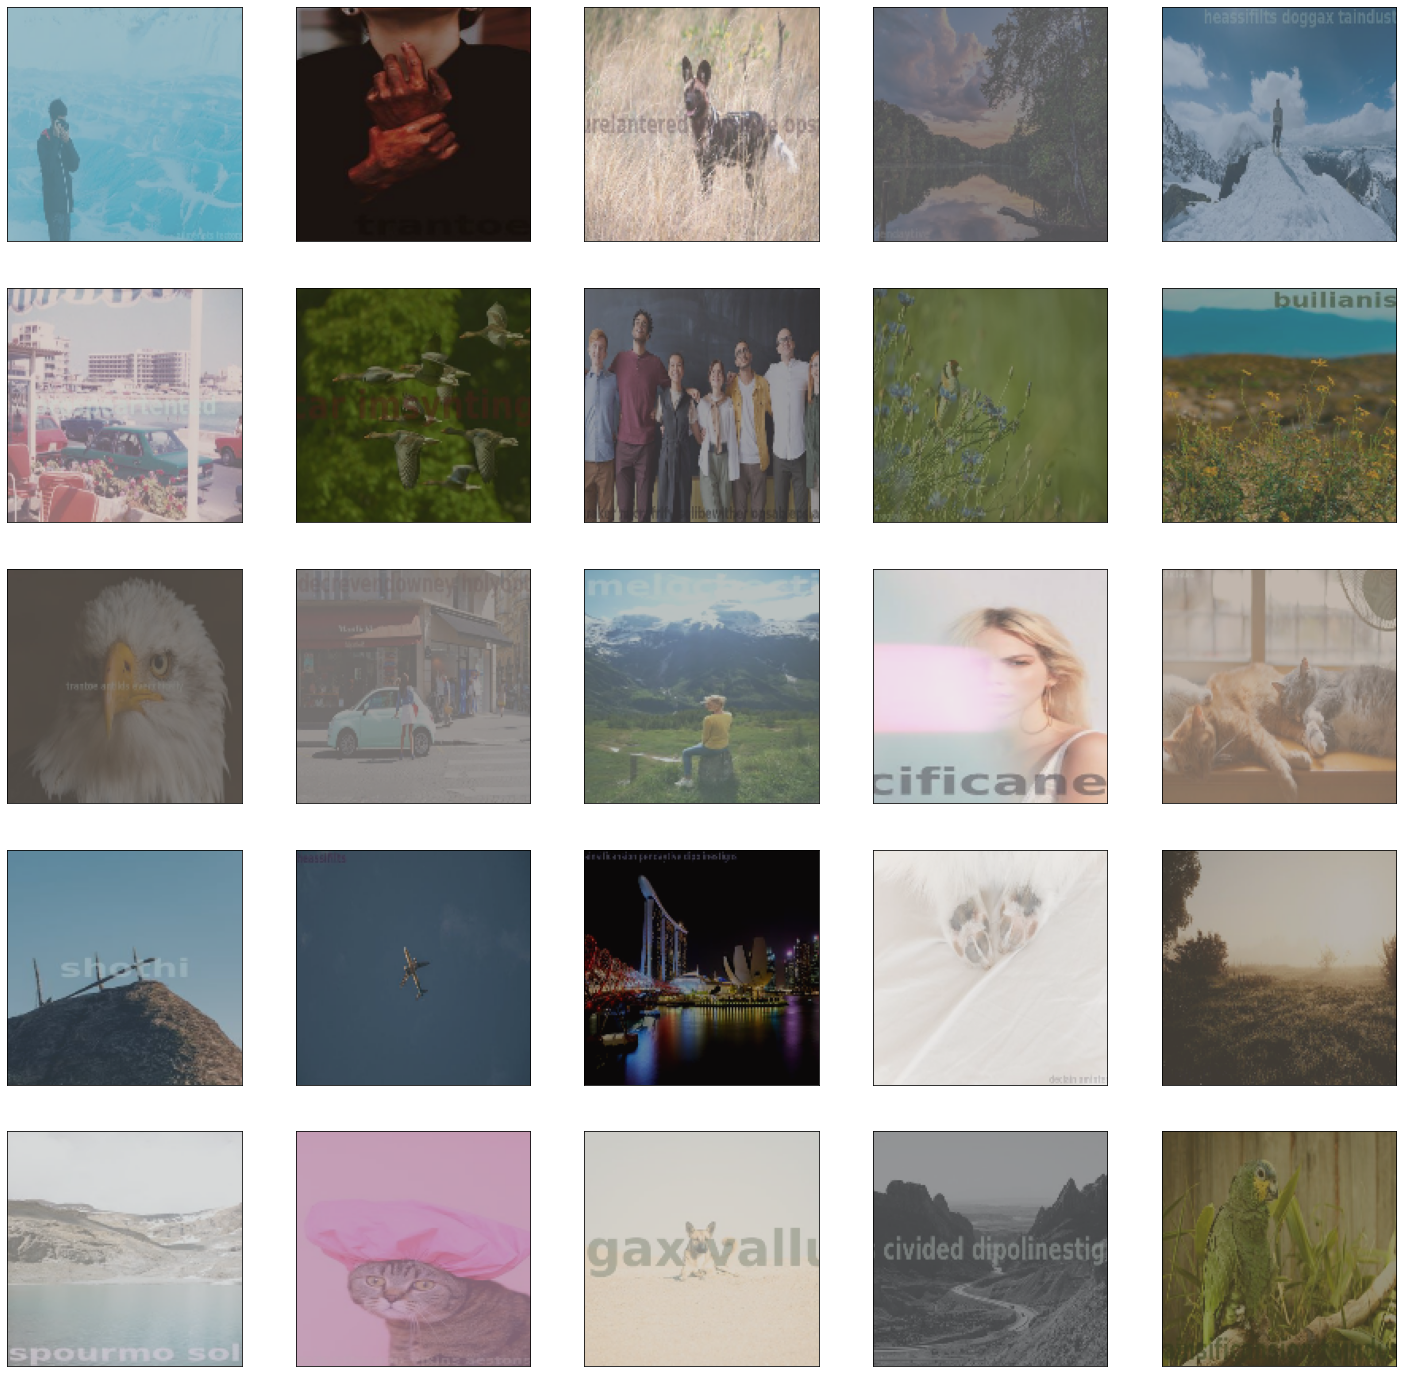

In [10]:
# Output Tensorflow data augmented images
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    augmented_image = data_augmentation(X_train[random.randint(1, len(X_train))]) # send 25 images into data augmentation
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)) # not using cv2 as it messed up the code
plt.show()

###Apply Data Augmentation

In [11]:
#apply data augmentation to the X_train and y_train

# data_augmented_X = [] 
# data_augmented_y = []

# for image in X_train:
#     data_augmented_X.append(data_augmentation(image))
    
# for image in y_train:
#     data_augmented_y.append(data_augmentation(image))

# # Append augmented data to train
# X_train = np.append(X_train, data_augmented_X, axis=0)
# y_train = np.append(y_train, data_augmented_y, axis=0)

In [12]:
# Output Tensorflow data augmented images
# plt.figure(figsize=(25,25))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     augmented_image = data_augmentation(X_train[random.randint(1, len(X_train))]) # send 25 images into data augmentation
#     plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)) # not using cv2 as it messed up the code
# plt.show()

In [10]:
# normalize 
X_train = X_train / 255
y_train = y_train / 255
X_test = X_test / 255
y_test = y_test / 255

# Graph Neural Network

###Graph Creation Functions

In [49]:
import torch
import numpy as np
from torch_geometric.data import Data

# Process an image into PyG graph.
# Each pixel is a node, and the edges are connections to 4-connectivity neighbors.
def image_to_graph(image):
    h, w = image.shape[:2]
    num_nodes = h * w
    edge_index = []

    for i in range(h):
        for j in range(w):
            node_id = i * w + j
            # Connect to the left pixel
            if j > 0:
              edge_index.append([node_id, node_id - 1])
            # Connect to the right pixel
            if j < w - 1:
              edge_index.append([node_id, node_id + 1])
            # Connect to the up pixel
            if i > 0:
              edge_index.append([node_id, node_id - w])
            # Connect to the bottom pixel
            if i < h - 1:
              edge_index.append([node_id, node_id + w])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(image.reshape(-1, image.shape[-1]), dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

# Process an image into PyG graph.
# Each pixel is a node, and the edges are connections to neighbor pixels defined using `half_filter_dim`.
# e.g `half_filter_dim` = 1, filter size is 3*3. `half_filter_dim` = 2, filter size is 5*5.
def image_to_graph_with_filter(image, half_filter_dim):
    h, w = image.shape[:2]
    num_nodes = h * w
    edge_index = []

    for i in range(h):
        for j in range(w):
            node_id = i * w + j

            for m in range(-half_filter_dim, half_filter_dim + 1):
                for n in range(-half_filter_dim, half_filter_dim + 1):
                    if m == 0 and n == 0:
                        continue

                    neighbor_i = i + m
                    neighbor_j = j + n

                    if (0 <= neighbor_i < h) and (0 <= neighbor_j < w):
                        neighbor_id = neighbor_i * w + neighbor_j
                        edge_index.append([node_id, neighbor_id])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(image.reshape(-1, image.shape[-1]), dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

def image_to_graph_with_filter_label(x, filter_dim, y):
  graph = image_to_graph_with_filter(x, filter_dim)
  graph.y = y
  return graph

###Models

In [24]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class TwoLayerGCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(TwoLayerGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x

# Convert labels to tensor
def labels_to_tensor(labels):
    return torch.tensor(labels.reshape(-1, labels.shape[-1]), dtype=torch.float)

###Training

In [50]:
from torch_geometric.loader import DataLoader
import torch.optim as optim

# Transforms images to data.
# train_graphs = [image_to_graph(i) for i in X_train]
# test_graphs = [image_to_graph(i) for i in X_test]

# Use filter to define neighbors.
filter_dim = 3
for i, (x, y) in enumerate(list(zip(X_train, y_train))):
  graph = image_to_graph_with_filter_label(x, filter_dim, y)
  with open(f'train_graph_{i}.pkl', 'wb') as f:
      pickle.dump(graph, f)

for i, (x, y) in enumerate(list(zip(X_test, y_test))):
  graph = image_to_graph_with_filter_label(x, filter_dim, y)
  with open(f'test_graph_{i}.pkl', 'wb') as f:
      pickle.dump(graph, f)
# train_graphs = [image_to_graph_with_filter(img, filter_dim) for img in X_train]
# test_graphs = [image_to_graph_with_filter(img, filter_dim) for img in X_test]

# Add y images label to graphs.
# for y in y_train:
#   train_graphs[i].y = labels_to_tensor(y)
# for y in y_test:
#   test_graphs[i].y = labels_to_tensor(y)

# Convert images and labels to PyG graphs
# train_labels = [labels_to_tensor(lbl) for lbl in y_train[:16,:,:,:]]
# test_labels = [labels_to_tensor(lbl) for lbl in y_test[:4,:,:,:]]

# Create DataLoaders
# train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

In [51]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import glob
from torch_geometric.data import Data, Dataset

class DiskGraphDataset(Dataset):
    def __init__(self, root, file_name_wildcard, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.file_name_wildcard = file_name_wildcard
        self.graph_filenames = glob.glob(file_name_wildcard)

    def len(self):
        return len(self.graph_filenames)

    def get(self, idx):
        filename = self.file_name_wildcard.replace("*", str(idx))
        with open(filename, 'rb') as f:
            graph = pickle.load(f)
        graph.y = labels_to_tensor(graph.y)
        return graph

In [76]:
from torch_geometric.loader import DataLoader

train_graphs = DiskGraphDataset("", "train_graph_*.pkl")
test_graphs = DiskGraphDataset("", "test_graph_*.pkl")
train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

In [16]:
import pickle

# Save PyG graphs to a file
def save_graphs_to_file(graphs, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graphs, f)

# Read PyG graphs from a file
def load_graphs_from_file(filename):
    with open(filename, 'rb') as f:
        graphs = pickle.load(f)
    return graphs

save_graphs_to_file(train_graphs, "filter_train_graphs.pkl")
save_graphs_to_file(test_graphs, "filter_test_graphs.pkl")

In [78]:
# GCN Training
# Initialize the model, loss function, and optimizer
loss_fn_arg = "MSE"
model = TwoLayerGCN(3, hidden_channels=16)
loss_fn = torch.nn.MSELoss()
if loss_fn_arg == "BCE":
  loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        # breakpoint()
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

Epoch 1/10, Loss: 0.03793236036488617
Epoch 2/10, Loss: 0.011721301088321277
Epoch 3/10, Loss: 0.010682898801116442
Epoch 4/10, Loss: 0.010031012595969845
Epoch 5/10, Loss: 0.009790244231804867
Epoch 6/10, Loss: 0.009739530357447538
Epoch 7/10, Loss: 0.009654706693254411
Epoch 8/10, Loss: 0.009557620680425316
Epoch 9/10, Loss: 0.009455967705104162
Epoch 10/10, Loss: 0.009396027191542089


In [79]:
# Testing
model.eval()
loss = 0
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        loss += loss_fn(out, data.y).item()

print(f"Node-level error: {loss / len(test_loader)}")

Node-level error: 0.009911158354952931


### Render Result

In [80]:
def predict(model, test_graphs):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # Disable gradient computation during inference
        for graph in test_graphs:
            # Convert node features and adjacency matrix to tensors if they are not already
            # if not isinstance(node_features, torch.Tensor):
            #     node_features = torch.tensor(node_features, dtype=torch.float32)
            # if not isinstance(adjacency_matrix, torch.Tensor):
            #     adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

            # # Move the tensors to the same device as the model
            # node_features = node_features.to(model.device)
            # adjacency_matrix = adjacency_matrix.to(model.device)

            # Make predictions using the model
            output = model(graph)
            predictions.append(output)

    return predictions

# Use the 'predict' function to get predictions for the test_graphs
test_predictions = predict(model, test_graphs)

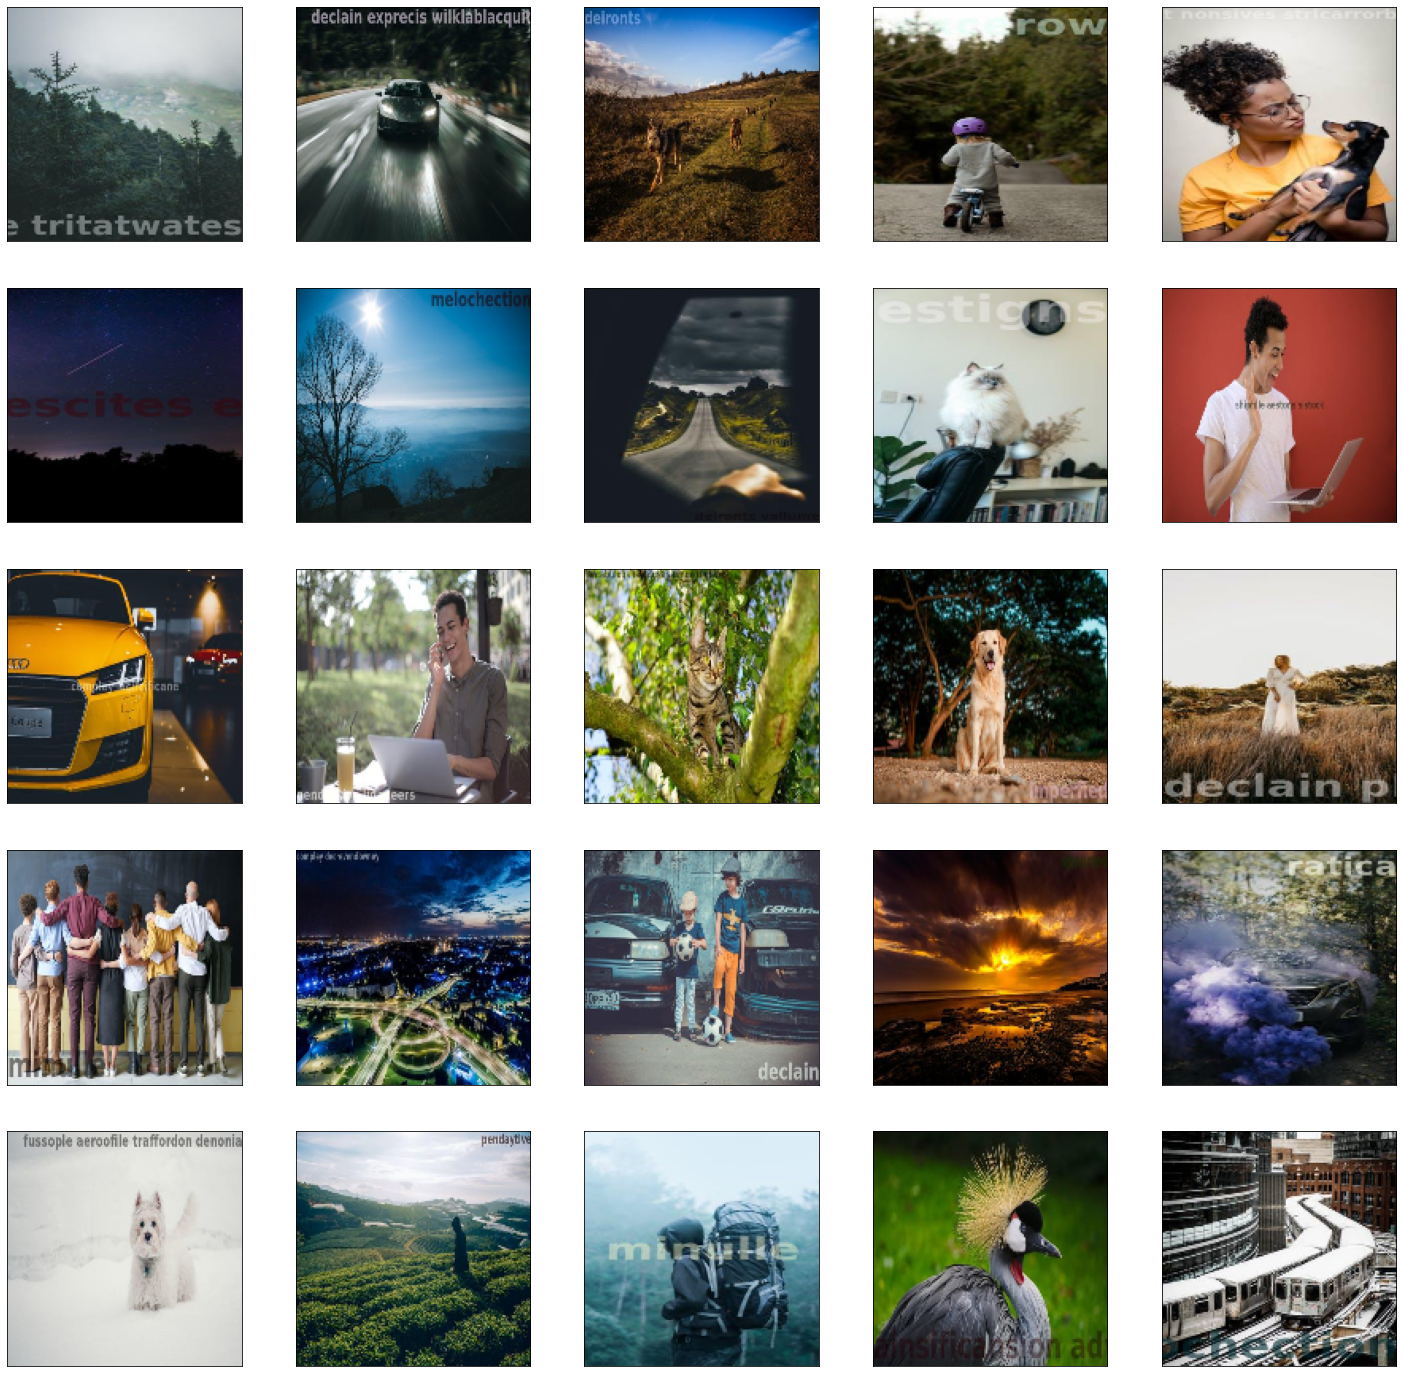

In [81]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

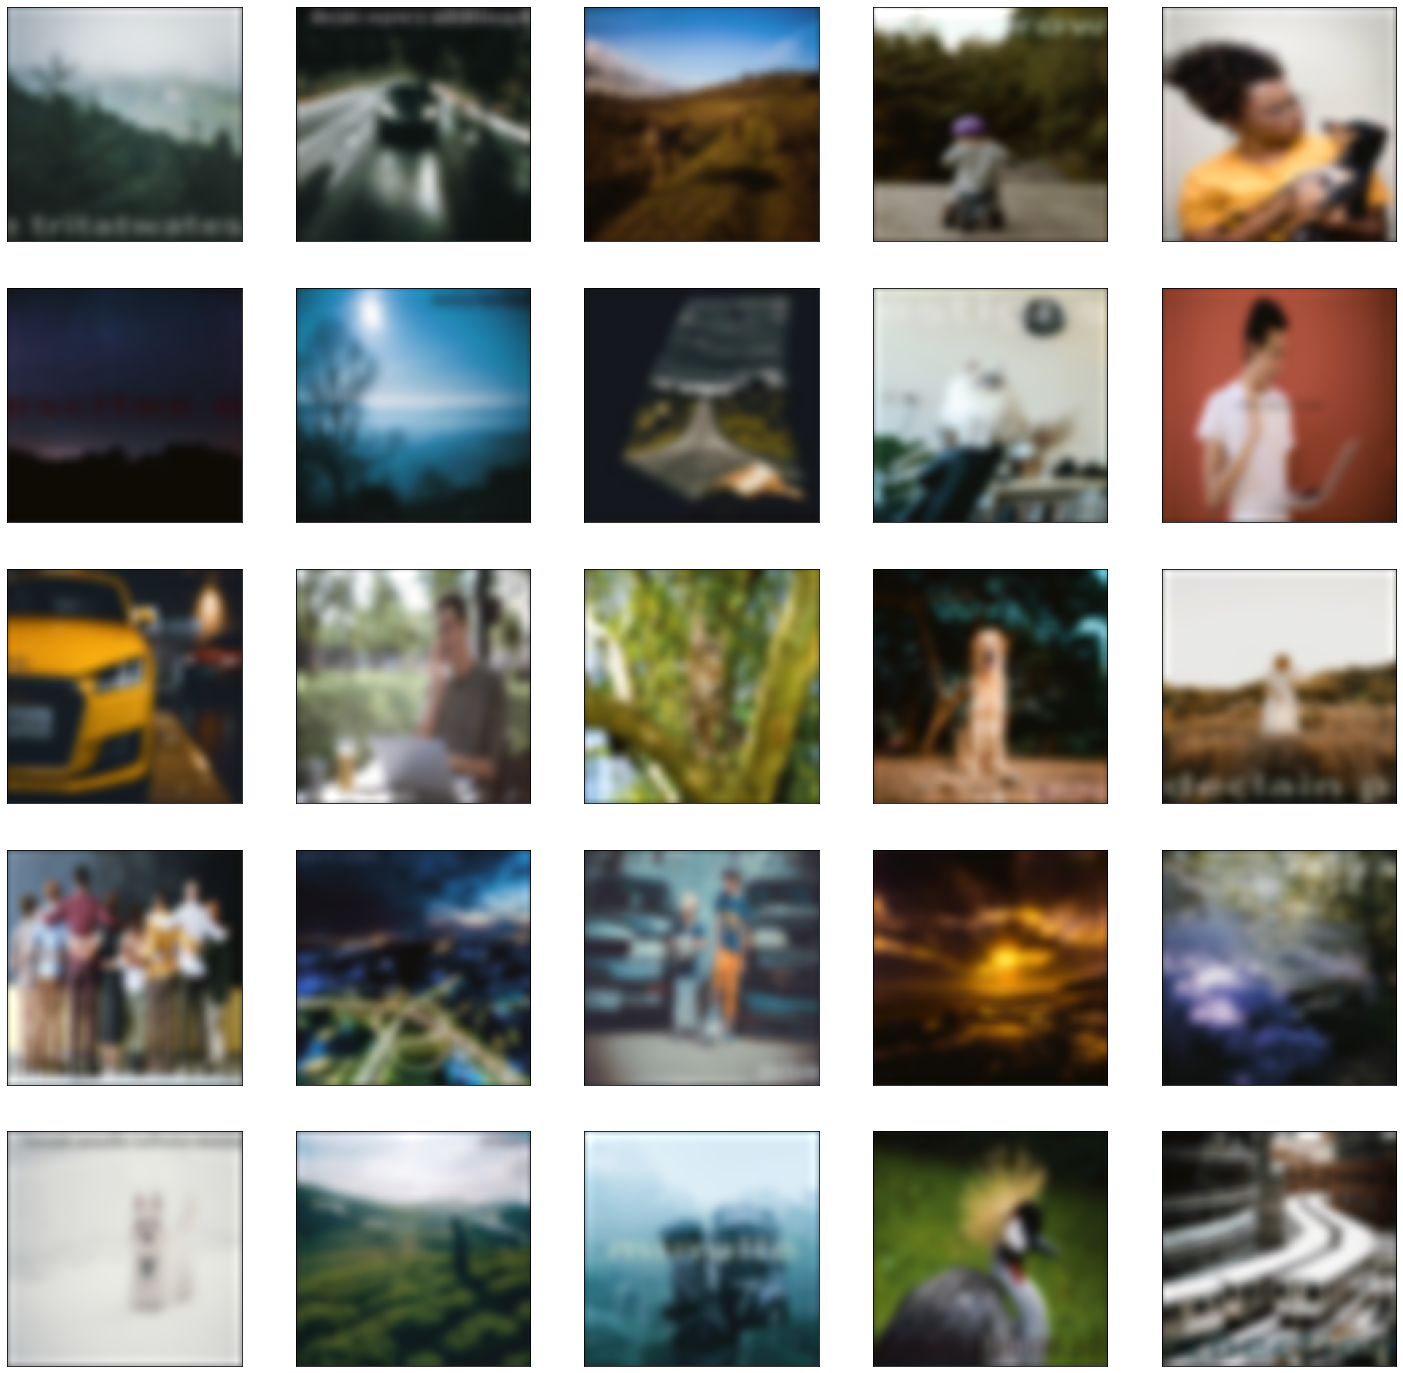

In [82]:
plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(test_predictions[i].reshape(width,height,3).detach().numpy(), cv2.COLOR_BGR2RGB))
plt.show()